В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [9]:
bank_df = pd.read_csv('/Users/macbook/Desktop/machine_learning_course/train.csv')

In [10]:
bank_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [11]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [12]:
# train and validation subsets
# use stratify
train_df, val_df = train_test_split(bank_df, test_size=0.2, random_state=42, stratify=bank_df['Exited'])


In [13]:
print('train_df.shape:', train_df.shape)
print('val_df.shape:', val_df.shape)


train_df.shape: (12000, 14)
val_df.shape: (3000, 14)


In [14]:
# check stratify distribution
print(train_df['Exited'].mean())
print(val_df['Exited'].mean())

0.2035
0.20333333333333334


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [15]:
target_col = 'Exited'
drop_cols = ['id', 'CustomerId', 'Surname', target_col]
input_cols = train_df.columns.difference(drop_cols).tolist()


In [16]:
print('input_cols:', input_cols)

input_cols: ['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']


In [17]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [18]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [19]:
print(train_inputs.shape, train_targets.shape)
print(val_inputs.shape, val_targets.shape)

(12000, 10) (12000,)
(3000, 10) (3000,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [20]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [21]:
print('numeric_cols:', numeric_cols)
print('categorical_cols:', categorical_cols)

numeric_cols: ['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
categorical_cols: ['Gender', 'Geography']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [22]:
# statistics
train_inputs[numeric_cols].describe().round(2)

,Age,Balance,CreditScore,EstimatedSalary,HasCrCard,IsActiveMember,NumOfProducts,Tenure
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,37.69,43008.17,658.84,117992.40,0.79,0.49,1.59,5.03
std,8.14,59906.63,72.33,45589.48,0.41,0.50,0.53,2.78
min,18.00,0.00,431.00,11.58,0.00,0.00,1.00,0.00
25%,32.00,0.00,603.00,83343.73,1.00,0.00,1.00,3.00
50%,37.00,0.00,661.00,123613.91,1.00,0.00,2.00,5.00
75%,42.00,109949.05,708.00,156912.81,1.00,1.00,2.00,7.00
max,74.00,209767.31,850.00,199992.48,1.00,1.00,4.00,10.00


З огляду на статистику, показники виглядають природними. Можна переходити до масштабування даних, оскільки поточний діапазон вимагає цього, як і сама задача логістічної регресії.

In [23]:
# scaling process
scaler = MinMaxScaler()

In [24]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [25]:
# transform train and validation
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])


In [26]:
train_inputs[numeric_cols].describe().round(2)

,Age,Balance,CreditScore,EstimatedSalary,HasCrCard,IsActiveMember,NumOfProducts,Tenure
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.35,0.21,0.54,0.59,0.79,0.49,0.20,0.50
std,0.15,0.29,0.17,0.23,0.41,0.50,0.18,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.00,0.41,0.42,1.00,0.00,0.00,0.30
50%,0.34,0.00,0.55,0.62,1.00,0.00,0.33,0.50
75%,0.43,0.52,0.66,0.78,1.00,1.00,0.33,0.70
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [27]:
train_inputs[categorical_cols].nunique()

Gender       2
Geography    3
dtype: int64

In [28]:
# encoding process
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [29]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [30]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['France', 'Germany', 'Spain'], dtype=object)]

In [31]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print('encoded_cols:', encoded_cols)

encoded_cols: ['Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']


In [32]:
# transform categorical columns
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])


In [33]:
train_inputs = train_inputs.drop(columns = categorical_cols)
val_inputs = val_inputs.drop(columns = categorical_cols)


In [34]:
display(train_inputs.head())
display(val_inputs.head())

,Age,Balance,CreditScore,EstimatedSalary,HasCrCard,IsActiveMember,NumOfProducts,Tenure,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
7180,0.214286,0.626382,0.599045,0.719772,1.0,1.0,0.000000,0.1,0.0,1.0,1.0,0.0,0.0
10393,0.375000,0.848836,0.603819,0.727603,1.0,0.0,0.000000,0.2,1.0,0.0,1.0,0.0,0.0
80,0.303571,0.554522,0.653938,0.872180,1.0,0.0,0.333333,0.6,0.0,1.0,0.0,1.0,0.0
3365,0.714286,0.000000,0.568019,0.257797,0.0,1.0,0.333333,0.0,0.0,1.0,0.0,0.0,1.0
12236,0.053571,0.000000,0.658711,0.742837,1.0,1.0,0.333333,0.3,0.0,1.0,1.0,0.0,0.0


,Age,Balance,CreditScore,EstimatedSalary,HasCrCard,IsActiveMember,NumOfProducts,Tenure,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
6490,0.500000,0.551870,0.675418,0.364704,1.0,1.0,1.000000,0.1,0.0,1.0,0.0,1.0,0.0
3646,0.410714,0.000000,0.386635,0.190942,1.0,1.0,0.333333,0.5,0.0,1.0,1.0,0.0,0.0
5306,0.357143,0.000000,0.715990,0.584853,0.0,1.0,0.333333,0.2,1.0,0.0,1.0,0.0,0.0
652,0.446429,0.742441,0.577566,0.558109,0.0,1.0,0.000000,0.4,1.0,0.0,1.0,0.0,0.0
2627,0.214286,0.000000,0.589499,0.718420,1.0,0.0,0.333333,0.4,1.0,0.0,0.0,0.0,1.0


1. Після пункту 3, де було визначено числові та категоріальні колонки за допомогою select_dtypes:
2. Проведено за допомогою "MinMaxScaler" масштабування числових даних на тренувальному наборі, аби не було витоку даних.
3. Закодовано категоріальні ознаки за допомогою "OneHotEncoder". Це було зроблено, тому що логістична регресія приймає лише числові дані, тому "Стать" та "Географію" треба було видозмінити. Фітила тільки на тренувальному наборі, додано нові колонки і видалено старі текстові колонки.
4. Перевірено результат, де видно, що тепер лише числові колонки.

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [79]:
!pip install pyarrow --quiet

In [35]:
print('train_inputs.shape:', train_inputs.shape)
print('train_targets.shape:', train_targets.shape)
print('val_inputs.shape:', val_inputs.shape)
print('val_targets.shape:', val_targets.shape)

train_inputs.shape: (12000, 13)
train_targets.shape: (12000,)
val_inputs.shape: (3000, 13)
val_targets.shape: (3000,)


In [36]:
train_inputs.to_parquet('train_inputs.parquet')
train_targets.to_frame().to_parquet('train_targets.parquet') # series
val_inputs.to_parquet('val_inputs.parquet')
val_targets.to_frame().to_parquet('val_targets.parquet') # series


In [37]:
os.listdir()

['HW_2_1_Аналіз_ознак_для_побудови_лінійної_регресії.ipynb',
 'EDA.ipynb',
 'HW_2_1_Матриці_і_вектори_(вступ_до_лін_алгебри).ipynb',
 'train_targets.parquet',
 'stat.ipynb',
 'EDA',
 'linear_regression_one_feature.ipynb',
 '2_Лінійна_регресія (1).ipynb',
 'EDA_Solutions.ipynb',
 'application_data.csv',
 'hwnp.ipynb',
 'medical-charges.csv',
 'linear_reg_one_feature.ipynb',
 'HW_1_1_Основи_статистики_Solution.ipynb',
 'Untitled.ipynb',
 'hwpd_tips.ipynb',
 'test.csv',
 'log_reg.joblib',
 'zet_test_hw.ipynb',
 'tips.csv',
 'Titanic-Dataset.csv',
 'eda_hw.ipynb',
 'functions_derivatives.ipynb',
 'test_inputs.parquet',
 'hw5.ipynb',
 '1.ipynb',
 'hw1.ipynb',
 'train_inputs.parquet',
 '.virtual_documents',
 'Лінійна_регресія_від_багатьох_змінних.ipynb',
 'val_inputs.parquet',
 'hw3.ipynb',
 'train.csv',
 '.ipynb_checkpoints',
 'HW_2_2_Логістична_регресія_з_scikit_learn.ipynb',
 'hw4.ipynb',
 'hw6.ipynb',
 '.git',
 'cars.csv',
 'titanic.ipynb',
 'hw2.ipynb',
 'val_targets.parquet',
 'hw

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [38]:
X_train = train_inputs
X_val = val_inputs

In [39]:
model = LogisticRegression(solver='liblinear')

In [40]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [41]:
# model predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)


In [42]:
print("Accuracy 'train':", accuracy_score(train_targets, train_predictions))
print("Accuracy 'val':", accuracy_score(val_targets, val_predictions))

Accuracy 'train': 0.87425
Accuracy 'val': 0.8716666666666667


In [43]:
# confusion matrix
cm_train = confusion_matrix(train_targets, train_predictions, normalize='true')

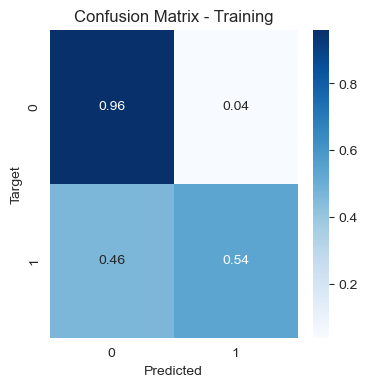

In [44]:
# training figure
plt.figure(figsize=(4, 4))
sns.heatmap(cm_train, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Confusion Matrix - Training')
plt.show()

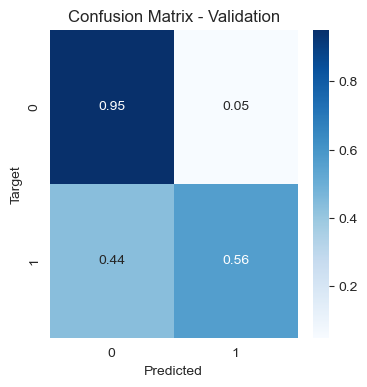

In [45]:
# validation figure
cm_val = confusion_matrix(val_targets, val_predictions, normalize='true')
plt.figure(figsize=(4, 4))
sns.heatmap(cm_val, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Confusion Matrix - Validation')
plt.show()

In [46]:
# F1 score
print("F1 score 'train':", f1_score(train_targets, train_predictions))
print("F1 score 'validation':", f1_score(val_targets, val_predictions))


F1 score 'train': 0.6352429296591733
F1 score 'validation': 0.641192917054986


In [47]:
# ROC Curve
y_train_proba = model.predict_proba(X_train)[:, 1]
y_val_proba = model.predict_proba(X_val)[:, 1]

In [48]:
# ROC curve train
fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, y_train_proba, pos_label=1)

In [49]:
# AUROC
roc_auc_train = auc(fpr_train, tpr_train)
print(f'AUROC train: {roc_auc_train:.2f}')


AUROC train: 0.88


In [50]:
# ROC curve validation
fpr_val, tpr_val, thresholds_val = roc_curve(val_targets, y_val_proba, pos_label=1)


In [51]:
# AUROC
roc_auc_val = auc(fpr_val, tpr_val)
print(f'AUROC validation: {roc_auc_val:.2f}')

AUROC validation: 0.88


Висновок: дана модель показує задовільну якість: AUROC train = 0.88, AUROC val = 0.87, Accuracy train = 0.87, Accuracy val = 0.87 (маємо подібні значення на тренувальному та валідаційному наборі). AUROC показує, що модель добре відрізняє клієнтів, які покинуть банк. А Confusion matrix чудово класифікує тих, хто не пішов (95%), проте тих, хто пішов передбачила лише на 45%. Модель можна ще допрацювати, можливо міняти поріг.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [52]:
# major class
train_targets.value_counts(normalize=True)

Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64

In [53]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [54]:
major_class = train_targets.value_counts().idxmax()

In [55]:
baseline_train_pred = np.full(len(train_targets), major_class)
baseline_val_pred = np.full(len(val_targets), major_class)

In [56]:
# accuracy
baseline_train_acc = accuracy_score(train_targets, baseline_train_pred)
baseline_val_acc = accuracy_score(val_targets, baseline_val_pred)

In [57]:
print('Majority class:', major_class)
print('baseline_train_acc:', baseline_train_acc)
print('baseline_val_acc:', baseline_val_acc)

Majority class: 0.0
baseline_train_acc: 0.7965
baseline_val_acc: 0.7966666666666666


In [58]:
logreg_train_pred = model.predict(X_train)
logreg_val_pred = model.predict(X_val)

In [59]:
logreg_train_acc = accuracy_score(train_targets, logreg_train_pred)
logreg_val_acc = accuracy_score(val_targets, logreg_val_pred)

In [60]:
print('Logistic regression Accuracy train:', logreg_train_acc)
print('Logistic regression Accuracy val:', logreg_val_acc)

Logistic regression Accuracy train: 0.87425
Logistic regression Accuracy val: 0.8716666666666667


Висновок: модель, яка прогнозує мажоритарний клас, виявила точність майже 80% на тренувальних та валідаційних, а логістична регресія показала вищу якість з точністю 87%. Дана модель краще відрізняє людей, які покинуть банк або залишаться.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [61]:
# save the model
joblib.dump(model, 'log_reg.joblib')

['log_reg.joblib']

In [62]:
# load the trained model
model_2 = joblib.load('log_reg.joblib')

In [63]:
# compare
pred1 = model.predict(X_val)
pred2 = model_2.predict(X_val)
print("Pred 1:", pred1)
print("Pred 2:", pred2)

Pred 1: [0. 0. 0. ... 0. 0. 0.]
Pred 2: [0. 0. 0. ... 0. 0. 0.]


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [66]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    df = input_df.copy()
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    encoded_arr = encoder.transform(df[categorical_cols])
    encoded_cols =list(encoder.get_feature_names_out(categorical_cols))
    df[encoded_cols] = encoded_arr
    df = df.drop(columns = categorical_cols)
    X_input = df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [68]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, bank_df[:5])

array([0.00654092, 0.0366679 , 0.37111937, 0.37653484, 0.97577854])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [69]:
test_raw_df = pd.read_csv('test.csv')

In [70]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.075316
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.035366
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.153210
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.194872
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.055660


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [71]:
submission = pd.read_csv('sample_submission.csv')

In [72]:
submission['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)
submission.head()

,id,Exited
0,15000,0.075316
1,15001,0.035366
2,15002,0.153210
3,15003,0.194872
4,15004,0.055660


In [73]:
submission.to_csv('submission_log_reg.csv', index=False)